<a href="https://colab.research.google.com/github/AndresMontesDeOca/TextMining/blob/main/EjemploClasificacionFakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo de clasificacion

## Importar librerias

In [32]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Exploracion Dataset

In [33]:
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth',300)

In [34]:
# Importo el dataset
# df = pd.read_csv('/content/archive (1).zip', encoding='utf-8') #Encoding
# df.shape

In [35]:
#Cargas de Datasets from Google Drive
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
id = '1FumqNME2V7YjMhY5pQIq5VgCW8HOAxYl'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('fake_or_real_news.csv')
data = pd.read_csv('fake_or_real_news.csv', encoding='utf-8') # Cargamos el Dataset
df = data

In [36]:
print("Cantidad de targets: ")
df.label.value_counts()

Cantidad de targets: 


REAL    3171
FAKE    3164
Name: label, dtype: int64

In [37]:
# Creo una caracteristica con el tamaño del titulo
df['title_text_size'] = df['title'].str.len()
df['title_text_words_count'] = df['title'].str.split().apply(len)
df['text_text_size'] = df['text'].str.len()
df['text_text_words_count'] = df['text'].str.split().apply(len)

In [38]:
import plotly.express as px
fig = px.histogram(df, x="title_text_words_count", color='label',histnorm='probability')
fig.show()

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=10):
    cv = CountVectorizer() # Agregar StopWords
    corpus_matrix = cv.fit_transform(corpus)
    corpus_matrix = pd.DataFrame.sparse.from_spmatrix(corpus_matrix, columns=cv.get_feature_names_out())
    aux = corpus_matrix.sum()
    aux=aux.to_frame('count')
    aux.sort_values(by='count',ascending=False,inplace=True)
    aux=aux.head(n)
    return aux

In [40]:
# Cantidad de tokens en todo el corpus
most_importants = get_top_n_words(df.text, n=500)
print(most_importants.head(10))
px.bar(most_importants, x=most_importants.index, y='count')

       count
the   291032
to    139881
of    129859
and   120142
in     98737
that   72595
is     54435
for    46478
on     40857
it     39597


In [41]:
# Cantidad de tokens en todo el corpus
most_importants = get_top_n_words(df[df.label=='FAKE'].text, n=500)
print(most_importants.head(10))
px.bar(most_importants, x=most_importants.index, y='count')

       count
the   129572
of     61012
to     60137
and    55139
in     40577
that   30424
is     27172
for    19615
it     17927
on     16082


In [42]:
# Cantidad de tokens en todo el corpus
most_importants = get_top_n_words(df[df.label=='REAL'].text, n=500)
print(most_importants.head(10))
px.bar(most_importants, x=most_importants.index, y='count')

       count
the   161460
to     79744
of     68847
and    65003
in     58160
that   42171
is     27263
for    26863
on     24775
he     23924


## Proceso NLP

In [43]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
stop_words = set( stopwords.words('english'))
stop_words.update(string.punctuation)

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

# Busqueda de la frecuencia de Bigramas
from nltk.collocations import BigramCollocationFinder,BigramAssocMeasures

import nltk
nltk.download('punkt')


# Pre procesamiento basico, agregar las etapas que considere necesario
def pre_procesamiento_texto(text):
  # Armo los tokens para procesar los datos
  tokens = word_tokenize(text)

  # Elimino las stopwords
  tokens = [t.lower() for t in tokens if t.lower() not in stop_words]

  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
text='Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam'
print(text)
pre_procesamiento_texto(text)

Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam


['daniel',
 'greenfield',
 'shillman',
 'journalism',
 'fellow',
 'freedom',
 'center',
 'new',
 'york',
 'writer',
 'focusing',
 'radical',
 'islam']

## Vectorizacion resultados

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label,test_size=.30)

In [47]:
# Vectorizacion de resultados BOW, tambien se puede probar TF-IDF
cv = CountVectorizer(tokenizer=pre_procesamiento_texto)#, max_features=1000)
X_train_transform = cv.fit_transform(X_train) # Armo matriz para entrenar

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [48]:
X_train_transform

<4434x79456 sparse matrix of type '<class 'numpy.int64'>'
	with 1286790 stored elements in Compressed Sparse Row format>

In [49]:
df_tranform = pd.DataFrame.sparse.from_spmatrix(X_train_transform, columns=cv.get_feature_names_out())
df_tranform

,'','08,'11,'12,'20s,'41,'47,'56,'60,'60s,...,🌍💚☮️,🎃,😀,😂,😉,😍,😭,🙂,🙄,🧀
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4430,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4431,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se puede ver que tenemos mas features que observaciones. Si se utiliza algun metodo de algebra lineal se necesitan tener al menos la misma cantidad de observaciones que de incognitas, sino existiran infinitas soluciones haciendo que el modelo no generalize correctamente.

https://builtin.com/data-science/curse-dimensionality

https://www.analyticsvidhya.com/blog/2021/04/the-curse-of-dimensionality-in-machine-learning/

Es recomendable utilizar tecnicas de Cross
Validation,  reduccion de dimencionalidad y seleccion de features

In [50]:
aux = df_tranform.sum().to_frame('count')
aux.sort_values(by='count',ascending=False,inplace=True)
aux=aux.head(5000)
px.bar(aux, x=aux.index, y='count')

In [51]:
print("Vocabulario de ", len(cv.get_feature_names_out()))

Vocabulario de  79456


In [52]:
X_train_transform.shape

(4434, 79456)

In [53]:
X_train_transform

<4434x79456 sparse matrix of type '<class 'numpy.int64'>'
	with 1286790 stored elements in Compressed Sparse Row format>

## Modelo Regresion Logistica

In [29]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_transform, y_train)

LogisticRegression(max_iter=1000)

### Resultados obtenidos

In [30]:
X_test_tranform = cv.transform(X_test)
y_pred = clf.predict(X_test_tranform.toarray())

In [31]:
clf.predict_proba(X_test_tranform.toarray())

array([[3.94703984e-07, 9.99999605e-01],
       [9.99562249e-01, 4.37751453e-04],
       [8.98043206e-09, 9.99999991e-01],
       ...,
       [9.49142551e-01, 5.08574489e-02],
       [2.60184559e-01, 7.39815441e-01],
       [4.81836793e-14, 1.00000000e+00]])

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        FAKE       0.49      0.49      0.49       964
        REAL       0.47      0.47      0.47       937

    accuracy                           0.48      1901
   macro avg       0.48      0.48      0.48      1901
weighted avg       0.48      0.48      0.48      1901



In [55]:
print(confusion_matrix(y_test, y_pred))

[[476 488]
 [499 438]]


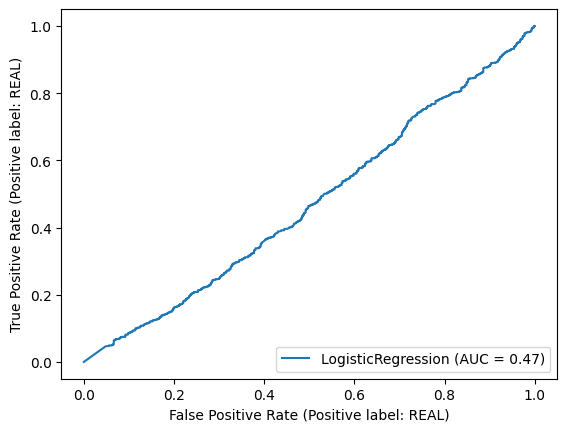

In [56]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf,X_test_tranform,y_test)

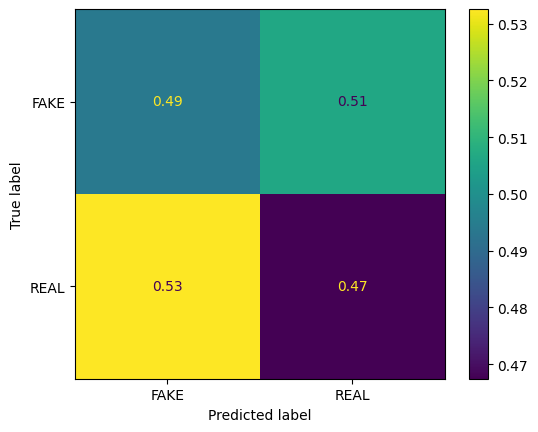

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf,X_test_tranform,y_test,normalize='true')

In [58]:
features = pd.DataFrame()
features['feature'] = cv.get_feature_names_out()
features['importance'] = clf.coef_.flatten()

features = features.sort_values(by='importance')

features_top_positivas = features[:200]
features_top_negativas = features[-200:]

px.bar(pd.concat([features_top_negativas, features_top_positivas]).sort_values(by='importance'), x='feature', y='importance')

ValueError: ignored

## Modelo SVM

**Support vector machines** (SVM) son un conjunto de métodos de aprendizaje supervisados classification, regression y outliers detection.

Las ventajas de los SVM son:<br>
  * Efectivo en espacios de altas dimensiones.
  * Sigue siendo efectivo en casos donde el número de dimensiones es mayor que el número de muestras, pero dependera del nivel de regularizacion
  * Utiliza un subconjunto de puntos de entrenamiento en la función de decisión (llamados vectores de soporte), por lo que también es eficiente en la memoria.
  * Versátil: se pueden especificar diferentes funciones de Kernel para la función de decisión. Se proporcionan núcleos comunes, pero también es posible especificar núcleos personalizados.

Las desventajas de los SVM son:<br>
  * Si el número de características es mucho mayor que el número de muestras, se necesita evitar el ajuste excesivo al elegir las funciones de Kernel y el término de regularización es crucial.
  * Los SVM no proporcionan directamente estimaciones de probabilidad, estas se calculan utilizando una costosa validación cruzada.    

In [59]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train_transform, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC()

### Resultados obtenidos

In [60]:
y_pred = clf.predict(X_test_tranform)

ValueError: ignored

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
print(confusion_matrix(y_test, y_pred))

In [61]:
features = pd.DataFrame()
features['feature'] = cv.get_feature_names_out()
features['importance'] = clf.coef_.flatten()

features = features.sort_values(by='importance')

features_top_positivas = features[:200]
features_top_negativas = features[-200:]

px.bar(pd.concat([features_top_negativas, features_top_positivas]).sort_values(by='importance'), x='feature', y='importance')

## Modelo RandomForest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_transform, y_train)

### Resultados obtenidos

In [ ]:
y_pred = clf.predict(X_test_tranform)

In [ ]:
print(classification_report(y_test, y_pred))

## Posibles cambios
* Entrenar con lematizador o Stemmer
* Buscar los hiperónimo de cada palabra
* Eliminar símbolos, numeros, tildes, ñ o caracteres inválidos
* Entrenar diferentes tipos de modelos -> SVM, Naive Bayes, regresión logística
* Cross validation
* Incluir Bigramas y Trigramas
* Explorar técnicas para reducción de dimensionalidad y seleccion de features
* Regularizacion
* Vectorizacion de tokens con TF-IDF
